Row 0: pred-true = -5571.0210, F2=1.0, F3=10.0, Input 10 = 88.0
Row 1: pred-true = -1864.8340, F2=2.0, F3=3.0, Input 10 = 291.0
Row 2: pred-true = 2911.2998, F2=1.0, F3=5.0, Input 10 = 35.0
Row 3: pred-true = -8618.8008, F2=5.0, F3=1.0, Input 10 = 2500.0
Row 4: pred-true = -11222.9805, F2=4.0, F3=1.0, Input 10 = 676.0
Row 5: pred-true = -8590.5312, F2=1.0, F3=4.0, Input 10 = 23.0
Row 6: pred-true = 7313.1587, F2=1.0, F3=4.0, Input 10 = 348.0
Row 7: pred-true = -548.3242, F2=3.0, F3=4.0, Input 10 = 261.0
Row 8: pred-true = -5616.8818, F2=2.0, F3=1.0, Input 10 = 516.0
Row 9: pred-true = -20582.5039, F2=4.0, F3=4.0, Input 10 = 50.0
Row 10: pred-true = -8069.8120, F2=4.0, F3=5.0, Input 10 = 59.0
Row 11: pred-true = 3053.5200, F2=5.0, F3=2.0, Input 10 = 15.0
Row 12: pred-true = -6745.8877, F2=12.0, F3=10.0, Input 10 = 262.0
Row 13: pred-true = -13183.2695, F2=1.0, F3=1.0, Input 10 = 110.0
Row 14: pred-true = -9170.5762, F2=6.0, F3=10.0, Input 10 = 11.0
Row 15: pred-true = -6521.1426, F2=1.0

/home/kamiar/chevron/Acid-neural-net/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


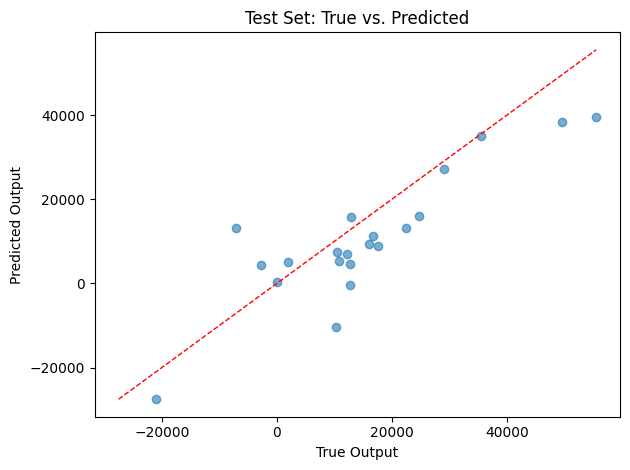

Test R²: 0.6865


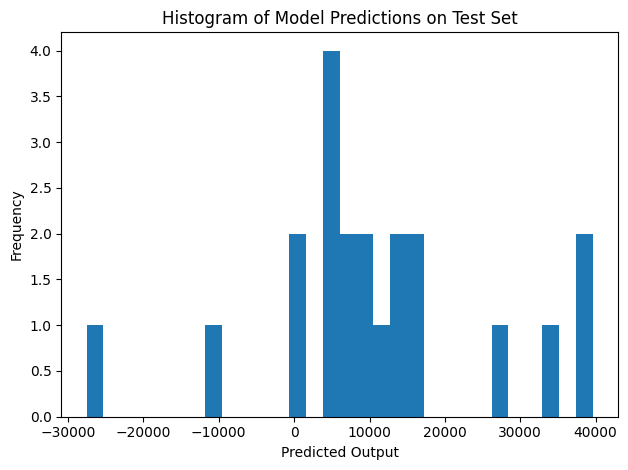

In [2]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pandas.api.types import CategoricalDtype

# --- 0) Load scalers ---
with open('scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)
with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# --- 1) Define fixed categories for Inputs 1–8 ---
categories_map = {
    'Input 1': [1, 2],
    'Input 2': [1, 2, 3, 4, 5],
    'Input 3': [1, 2, 3, 4, 5],
    'Input 4': list(range(1, 18)),
    'Input 5': list(range(1, 6)),
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
    'Input 8': list(range(1, 11)),
}

# --- 2) Rebuild model architecture ---
def build_model(input_dim, hidden_dims, activation='ReLU'):
    act_key = activation.strip().lower()
    layers = []
    in_dim = input_dim
    for h in hidden_dims:
        layers.append(nn.Linear(in_dim, h))
        if act_key not in ('linear', 'none'):
            layers.append(getattr(nn, activation)())
        in_dim = h
    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

# --- 3) Load test set ---
DATA_PATH      = '/home/kamiar/chevron/Acid-neural-net/First data/data/test_cleaned.csv'
MODEL_PATH     = '/home/kamiar/chevron/Acid-neural-net/First data/good_Models/trained_model_50c0e94e.pt'
HIDDEN_DIMS    = [8, 4]
ACTIVATION     = 'Softplus'

df_test = pd.read_csv(DATA_PATH)

# --- 4) Build feature matrix ---
# 4a) One-hot encode Inputs 1–8 using fixed categories
cat_frames = []
for i in range(1, 9):
    col = f'Input {i}'
    dtype = CategoricalDtype(categories=categories_map[col], ordered=False)
    s = df_test[col].astype(dtype)
    d = pd.get_dummies(s, prefix=col, dtype=float)
    cat_frames.append(d)
df_cat = pd.concat(cat_frames, axis=1)

# 4b) Normalize numeric Inputs 9–18
num_cols = [f'Input {i}' for i in range(9, 19)]
df_num   = df_test[num_cols].apply(pd.to_numeric, errors='coerce')
X_num    = scaler_X.transform(df_num.values)

# 4c) Combine
X_test = np.hstack([df_cat.values.astype(np.float32),
                    X_num.astype(np.float32)])

# --- 5) Load model ---
model = build_model(X_test.shape[1], HIDDEN_DIMS, ACTIVATION)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# --- 6) Predict and inverse-transform ---
with torch.no_grad():
    y_pred_norm = model(torch.from_numpy(X_test)).cpu().numpy().ravel()
y_pred = scaler_y.inverse_transform(y_pred_norm.reshape(-1,1)).ravel()

# True outputs
y_true = df_test['Output 1'].values.astype(np.float32)

# --- 6.5) Print per-point error and quality F2, F3 ---
errors = y_pred - y_true
for idx, (err, f2, f3, i10) in enumerate(zip(errors, df_test['F2'], df_test['F3'], df_test['Input 10'])):
    print(f"Row {idx}: pred-true = {err:.4f}, F2={f2}, F3={f3}, Input 10 = {i10}")

# --- 7) Scatter plot: True vs. Predicted ---
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.6)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel('True Output')
plt.ylabel('Predicted Output')
plt.title('Test Set: True vs. Predicted')
plt.tight_layout()
plt.show()

# --- 8) Compute R² ---
r2 = r2_score(y_true, y_pred)
print(f"Test R²: {r2:.4f}")

# --- 9) Histogram of predicted outputs ---
plt.figure()
plt.hist(y_pred, bins=30)
plt.xlabel('Predicted Output')
plt.ylabel('Frequency')
plt.title('Histogram of Model Predictions on Test Set')
plt.tight_layout()
plt.show()
